In [1]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from statsmodels.tools.eval_measures import rmse
from sklearn.tree import DecisionTreeRegressor

# Importing and Exploring the Dataset

In [2]:
transaction_data = pd.read_excel('D:\\Atharva\\Data Science\\Data Sets\\ANZ Virtual Internship\\ANZ synthesised transaction dataset.xlsx') 

In [3]:
transaction_data.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


In [4]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
status               12043 non-null object
card_present_flag    7717 non-null float64
bpay_biller_code     885 non-null object
account              12043 non-null object
currency             12043 non-null object
long_lat             12043 non-null object
txn_description      12043 non-null object
merchant_id          7717 non-null object
merchant_code        883 non-null float64
first_name           12043 non-null object
balance              12043 non-null float64
date                 12043 non-null datetime64[ns]
gender               12043 non-null object
age                  12043 non-null int64
merchant_suburb      7717 non-null object
merchant_state       7717 non-null object
extraction           12043 non-null object
amount               12043 non-null float64
transaction_id       12043 non-null object
country              12043 non-null object
customer_id          12043 n

In [5]:
transaction_data.shape

(12043, 23)

In [6]:
transaction_data.describe()

,card_present_flag,merchant_code,balance,age,amount
count,7717.000000,883.0,12043.000000,12043.000000,12043.000000
mean,0.802644,0.0,14704.195553,30.582330,187.933588
std,0.398029,0.0,31503.722652,10.046343,592.599934
min,0.000000,0.0,0.240000,18.000000,0.100000
25%,1.000000,0.0,3158.585000,22.000000,16.000000
50%,1.000000,0.0,6432.010000,28.000000,29.000000
75%,1.000000,0.0,12465.945000,38.000000,53.655000
max,1.000000,0.0,267128.520000,78.000000,8835.980000


In [7]:
transaction_data.isnull().sum()/transaction_data.shape[0]*100

status                0.000000
card_present_flag    35.921282
bpay_biller_code     92.651333
account               0.000000
currency              0.000000
long_lat              0.000000
txn_description       0.000000
merchant_id          35.921282
merchant_code        92.667940
first_name            0.000000
balance               0.000000
date                  0.000000
gender                0.000000
age                   0.000000
merchant_suburb      35.921282
merchant_state       35.921282
extraction            0.000000
amount                0.000000
transaction_id        0.000000
country               0.000000
customer_id           0.000000
merchant_long_lat    35.921282
movement              0.000000
dtype: float64

# INSIGHTS - 
### Features like bpay_biller_code and merchant_code have almost 90% null values and can be dropped 
### Features like merchant_id , merchant_code , merchant_suburb and merchant_state have about 35% null values and might need imputations to correct these features.

# Data Preprocessing

1. Impute null values in columns.
2. Remove columns that has only 1 unique value or all values are unique
3. Calculate the Annual Salary from the total monthly salary Calculated using the data.
4. Remove redundant columns
5. Calculate annual expenditure per customer according to the debits each month.

In [8]:
# Getting unique values as %

col_uniq_pct = pd.DataFrame(transaction_data.nunique()/len(transaction_data)).reset_index()
col_uniq_pct.columns = ['column', 'unique_pct']
col_uniq_pct

,column,unique_pct
0,status,0.000166
1,card_present_flag,0.000166
2,bpay_biller_code,0.000249
3,account,0.008304
4,currency,0.000083
5,long_lat,0.008304
6,txn_description,0.000498
7,merchant_id,0.475380
8,merchant_code,0.000083
9,first_name,0.006643


### Dropping currency, country ,merchant_code as they have very limited number of unique values . also dropping the extraction column as we already have the date . Dropping transaction_id as well as it has all unique values. Dropping long_lat and merchant_long_lat as we are not interested in any geographical data.

In [9]:
transaction_data.drop(['bpay_biller_code','merchant_code','transaction_id','country','currency','long_lat','account','merchant_id','extraction','merchant_long_lat'],axis=1,inplace=True)

In [10]:
transaction_data['Month_of_Transaction'] = pd.DatetimeIndex(transaction_data['date']).month
Salary = transaction_data[(transaction_data['txn_description'] == 'PAY/SALARY')& (transaction_data['movement'] == 'credit')]
Salary= Salary.pivot_table(index='customer_id',values='amount',aggfunc=np.sum)
Salary.reset_index(inplace=True)
Salary['Annual_Salary'] = (round(Salary['amount']*4,2))

## Calculated Annual Salary based on the salary received over 3 months and then multiplying it by 4 to calculate for 12 months.

In [11]:
Salary.head()

,customer_id,amount,Annual_Salary
0,CUS-1005756958,12616.11,50464.44
1,CUS-1117979751,25050.55,100202.20
2,CUS-1140341822,11499.06,45996.24
3,CUS-1147642491,22248.07,88992.28
4,CUS-1196156254,27326.11,109304.44


In [12]:
Monthly_expenditure = transaction_data[ transaction_data['movement'] == 'debit']
Monthly_expenditure = Monthly_expenditure.pivot_table(index='customer_id',values='amount',aggfunc=np.sum)
Monthly_expenditure['Average_annual_Expenditure'] = round(Monthly_expenditure['amount']*4)
Monthly_expenditure.reset_index(inplace=True)
Salary= pd.merge(Salary,Monthly_expenditure[['customer_id','Average_annual_Expenditure']],on='customer_id', how='left')

In [13]:
Salary

,customer_id,amount,Annual_Salary,Average_annual_Expenditure
0,CUS-1005756958,12616.11,50464.44,14611.0
1,CUS-1117979751,25050.55,100202.20,35735.0
2,CUS-1140341822,11499.06,45996.24,22046.0
3,CUS-1147642491,22248.07,88992.28,26931.0
4,CUS-1196156254,27326.11,109304.44,34898.0
5,CUS-1220154422,15976.52,63906.08,18478.0
6,CUS-1233833708,7155.96,28623.84,12918.0
7,CUS-1271030853,16214.10,64856.40,51463.0
8,CUS-127297539,14804.27,59217.08,28210.0
9,CUS-134193016,14165.76,56663.04,12260.0


In [14]:
Salary['Expenditure_as_percentage'] = (round((Salary['Average_annual_Expenditure']/Salary['Annual_Salary'])*100,2))

In [15]:
Salary

,customer_id,amount,Annual_Salary,Average_annual_Expenditure,Expenditure_as_percentage
0,CUS-1005756958,12616.11,50464.44,14611.0,28.95
1,CUS-1117979751,25050.55,100202.20,35735.0,35.66
2,CUS-1140341822,11499.06,45996.24,22046.0,47.93
3,CUS-1147642491,22248.07,88992.28,26931.0,30.26
4,CUS-1196156254,27326.11,109304.44,34898.0,31.93
5,CUS-1220154422,15976.52,63906.08,18478.0,28.91
6,CUS-1233833708,7155.96,28623.84,12918.0,45.13
7,CUS-1271030853,16214.10,64856.40,51463.0,79.35
8,CUS-127297539,14804.27,59217.08,28210.0,47.64
9,CUS-134193016,14165.76,56663.04,12260.0,21.64


## Adding Gender and age of customer from main dataframe to the newly created Salary dataframe.

In [17]:
Age_Gender = transaction_data[['customer_id','age','gender']]
Age_Gender.drop_duplicates(inplace=True)
Salary = pd.merge(Salary,transaction_data[['customer_id','age']],on='customer_id', how='left')
Salary = pd.merge(Salary,transaction_data[['customer_id','gender']],on='customer_id', how='left')

In [27]:
Salary

,customer_id,amount,Annual_Salary,Average_annual_Expenditure,Expenditure_as_percentage,age,gender
0,CUS-1005756958,12616.11,50464.44,14611.0,28.95,53,F
5329,CUS-1117979751,25050.55,100202.20,35735.0,35.66,21,M
15329,CUS-1140341822,11499.06,45996.24,22046.0,47.93,28,M
21729,CUS-1147642491,22248.07,88992.28,26931.0,30.26,34,F
35653,CUS-1196156254,27326.11,109304.44,34898.0,31.93,34,F
95678,CUS-1220154422,15976.52,63906.08,18478.0,28.91,25,F
101303,CUS-1233833708,7155.96,28623.84,12918.0,45.13,44,M
103239,CUS-1271030853,16214.10,64856.40,51463.0,79.35,30,F
116928,CUS-127297539,14804.27,59217.08,28210.0,47.64,20,F
156529,CUS-134193016,14165.76,56663.04,12260.0,21.64,21,F


## Plotting Scatterplot of different features with our target variable.

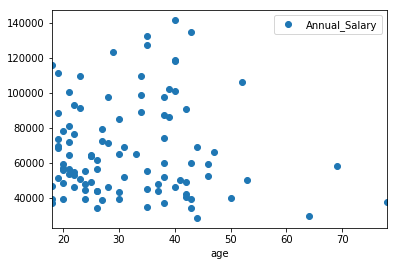

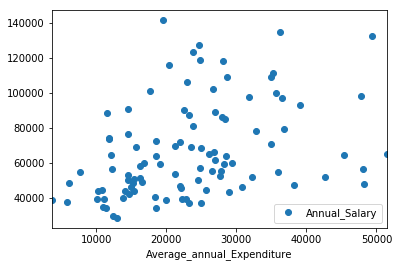

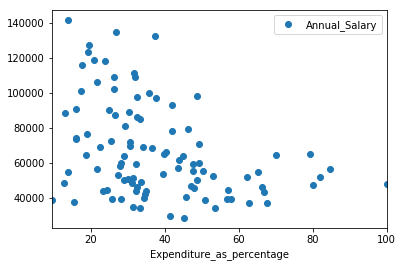

In [28]:
Salary.plot(x='age',y='Annual_Salary',style='o')
Salary.plot(x='Average_annual_Expenditure',y='Annual_Salary',style='o')
Salary.plot(x='Expenditure_as_percentage',y='Annual_Salary',style='o')

## Insights - As we can see that there isn't a high correlation between the target feature and the independent features.

# Model Building - 


### Converting the gender column into numerical using one-hot encoding



In [30]:
Salary = pd.get_dummies(Salary,columns=['gender'])

# Linear Regression-

In [31]:
X = Salary.drop(columns=['customer_id','amount','Annual_Salary'])
Y = Salary['Annual_Salary']
x_train,x_test,y_train,y_test = train_test_split(X,Y,train_size=0.7,random_state=7)
lr = LinearRegression()
lr.fit(x_train,y_train)
pred = lr.predict(x_test)
rmse(pred,y_test)

9848.015357133772

In [32]:
lr.score(x_train,y_train)

0.8601022400603431

# Decision Tree Regressor - 

In [33]:
dt = DecisionTreeRegressor()
dt.fit(x_train,y_train)
pred_new = dt.predict(x_test)
rmse(pred_new,y_test)

15205.049814956434

# Conclusion - 
    
   As we can see that the accuracy of the linear regression model is 86 % but it has an rmse value of 9848 and the Decision Tree Regressor has an rmse of 15205. More data is required to accurately predict the customers annual Salary . 